In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler
from concurrent.futures import ProcessPoolExecutor, as_completed
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from concurrent.futures import ThreadPoolExecutor, as_completed

In [5]:
def preprocess_images(images, target_size=(300, 300)):
    preprocessed_images = []
    for img in images:
        if img.shape[:2] != target_size:
            img = cv.resize(img, target_size)
        if len(img.shape) == 2:
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        if img.shape[2] == 4:
            img = cv.cvtColor(img, cv.COLOR_BGRA2BGR)
        if img.shape[2] != 3: 
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        preprocessed_images.append(img)
    return np.array(preprocessed_images)

In [6]:
def display_sample(images, labels):
    unique_labels = list(set(labels))
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))
    
    for i, label in enumerate(unique_labels):
        idx = labels.index(label)
        img = images[idx]
        
        # Ensure the image is within the valid range
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = np.clip(img, 0, 1)
        else:
            img = np.clip(img, 0, 255).astype(np.uint8)
        
        axes[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axes[i].set_title(label)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [7]:
def insertGambar(folder):
    data = []
    datalabel = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in tqdm(os.listdir(label_folder)):
            img_path = os.path.join(label_folder, filename)
            img = plt.imread(img_path)
            if img is not None:
                data.append(img)
                datalabel.append(label)
    return data, datalabel

In [9]:
def rotasi(image, derajat):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv.getRotationMatrix2D(center, derajat, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated

In [10]:
def augmentasi(data, labels, banyakData):
    augmented_data = []
    augmented_labels = []
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        for j in range(banyakData):
            if j % 2 == 0:
                rotated_90 = rotasi(data[i], 90)
                augmented_data.append(rotated_90)
                augmented_labels.append(labels[i])
            elif j % 2 == 1:
                rotated_minus_90 = rotasi(data[i], -90)
                augmented_data.append(rotated_minus_90)
                augmented_labels.append(labels[i])
    augmented_filenames = [f"{label}_augmented_{idx}" for idx, label in enumerate(augmented_labels)]
    return augmented_data, augmented_filenames, augmented_labels

In [11]:
# Load, preprocess, and augment images
data, label = insertGambar("Sea Animal")
print("Data: ", len(data))
print("Label: ", len(label))

100%|██████████| 200/200 [00:00<00:00, 485.80it/s]

Data:  1150
Label:  1150


In [12]:
# Preprocess images
dataResize = preprocess_images(data, target_size=(300, 300))
augmented_data, augmented_filenames, augmented_labels = augmentasi(dataResize, label, 2)
print("Jumlah total dataset setelah augmentasi:", len(augmented_data))


100%|██████████| 1150/1150 [00:04<00:00, 236.23it/s]

Jumlah total dataset setelah augmentasi: 3450


In [13]:
def grayscale(data):
    dataGray = []
    for img in data:
        if len(img.shape) == 3:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            gray = img
        dataGray.append(gray)
    return dataGray

dataGray = grayscale(augmented_data)

In [14]:
def contrast(data):
    return np.sum(data * (np.arange(data.shape[0])[:, None] - np.arange(data.shape[1])) ** 2)

def dissimilarity(data):
    return np.sum(data * np.abs(np.arange(data.shape[0])[:, None] - np.arange(data.shape[1])))

def homogeneity(data):
    return np.sum(data / (1.0 + (np.arange(data.shape[0])[:, None] - np.arange(data.shape[1])) ** 2))

def energy(data):
    return np.sum(data ** 2)

def correlation(data):
    mean = np.zeros((2))
    std = np.zeros((2))
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean[0] += i * data[i, j]
            mean[1] += j * data[i, j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std[0] += (i - mean[0]) ** 2 * data[i, j]
            std[1] += (j - mean[1]) ** 2 * data[i, j]
    std[0] = np.sqrt(std[0])
    std[1] = np.sqrt(std[1])
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i - mean[0]) * (j - mean[1]) * data[i, j] / (std[0] * std[1])
    return hasil

def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy

def asm(data):
    return np.sum(data ** 2)

def derajat(image, derajat):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv.getRotationMatrix2D(center, derajat, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated

def ekstraksi(dataContours):
    hasil = []
    for img in tqdm(dataContours):
        data = []
        data.append(derajat(img, 0))
        data.append(derajat(img, 45))
        data.append(derajat(img, 90))
        data.append(derajat(img, 135))
        hasil.append(data)
    return hasil


In [15]:
hasil = ekstraksi(dataGray)

100%|██████████| 3450/3450 [00:28<00:00, 121.10it/s]


In [16]:

def extract_features_for_image(img_set, idx):
    extracted_data = [f"file_{idx}"]
    for img in img_set:
        extracted_data.append(contrast(img))
    for img in img_set:
        extracted_data.append(dissimilarity(img))
    for img in img_set:
        extracted_data.append(homogeneity(img))
    for img in img_set:
        extracted_data.append(energy(img))
    for img in img_set:
        extracted_data.append(correlation(img))
    for img in img_set:
        extracted_data.append(entropy(img))
    for img in img_set:
        extracted_data.append(asm(img))
    return extracted_data

def parallel_feature_extraction(hasil, num_threads=8):
    results = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(extract_features_for_image, hasil[i], i) for i in range(len(hasil))]
        for future in tqdm(as_completed(futures), total=len(futures)):
            results.append(future.result())
    return results


In [17]:
num_threads = 8 
result = parallel_feature_extraction(hasil, num_threads=num_threads)

100%|██████████| 3450/3450 [3:53:03<00:00,  4.05s/it]  


In [18]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'entropy', 'asm']
columns = ['filename'] + [f"{f}_{a}" for f in fiturs for a in angles]
df = pd.DataFrame(result, columns=columns)

In [35]:
df.to_csv("P0_ekstraksi_fitur.csv", index=False)

In [36]:
from sklearn.impute import SimpleImputer

X = df.drop(['filename'], axis=1)
y = augmented_labels

print("Number of NaNs in X:", X.isna().sum().sum())

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

Number of NaNs in X: 0


In [37]:
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_balanced)
y_test_encoded = encoder.transform(y_test)

In [38]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(X_train_balanced, y_train_encoded)
y_pred_knn = knn.predict(X_test)
print('Accuracy (KNN):', accuracy_score(y_test_encoded, y_pred_knn))

Accuracy (KNN): 0.6710144927536232


In [39]:
svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(X_train_balanced, y_train_encoded)
y_pred_svm = svm.predict(X_test)
print('Accuracy (SVM):', accuracy_score(y_test_encoded, y_pred_svm))

Accuracy (SVM): 0.5449275362318841


In [40]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(X_train_balanced, y_train_encoded)
y_pred_rfc = rfc.predict(X_test)
print('Accuracy (RF):', accuracy_score(y_test_encoded, y_pred_rfc))

Accuracy (RF): 0.755072463768116


In [41]:
model_dict = {
    'KNN': knn,
    'SVM': svm,
    'RF': rfc
}

df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())

for model_name, model in model_dict.items():
    y_pred = model.predict(X_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test_encoded, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test_encoded, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test_encoded, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test_encoded, y_pred, average='weighted')



In [42]:
print(df_eval)

     Accuracy Precision    Recall  F1 Score
KNN  0.671014  0.673427  0.671014  0.670043
SVM  0.544928  0.538977  0.544928  0.539096
RF   0.755072  0.756856  0.755072  0.753014


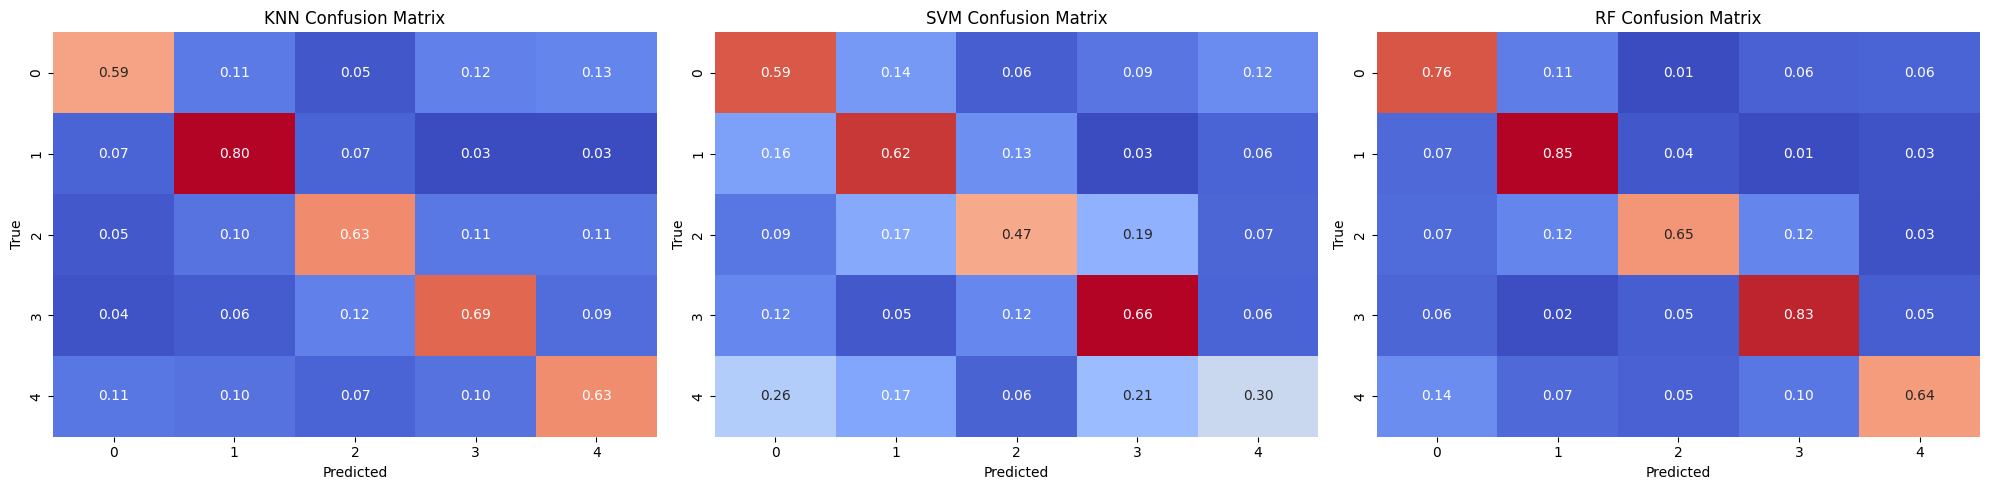

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, (model_name, model) in enumerate(model_dict.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_encoded, y_pred, labels=np.unique(y_test_encoded))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(f'{model_name} Confusion Matrix')

plt.tight_layout()
plt.show()

In [45]:

X_cnn = preprocess_images(augmented_data)
y_cnn = np.array(augmented_labels)
y_cnn_encoded = encoder.fit_transform(y_cnn)

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn_encoded, test_size=0.2, random_state=42)
X_cnn_train = X_cnn_train / 255.0
X_cnn_test = X_cnn_test / 255.0

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_cnn_encoded)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\HAPPY COM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
cnn_history = cnn_model.fit(
    X_cnn_train, y_cnn_train,
    epochs=10,
    validation_data=(X_cnn_test, y_cnn_test)
)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4639 - loss: 1.6203 - val_accuracy: 0.6623 - val_loss: 0.8720
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6494 - loss: 0.9201 - val_accuracy: 0.7580 - val_loss: 0.6689
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7450 - loss: 0.7012 - val_accuracy: 0.7551 - val_loss: 0.6856
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7860 - loss: 0.6085 - val_accuracy: 0.8072 - val_loss: 0.5698
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8273 - loss: 0.4716 - val_accuracy: 0.8348 - val_loss: 0.5847
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8554 - loss: 0.4017 - val_accuracy: 0.8319 - val_loss: 0.5408
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9065 - loss: 0.2896 - val_accuracy: 0.8304 - val_loss: 0.5980
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9250 - loss: 0.2073 - val_accuracy: 0.8420 - v

In [47]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_cnn_test, y_cnn_test)
y_cnn_pred = cnn_model.predict(X_cnn_test)
y_cnn_pred_classes = np.argmax(y_cnn_pred, axis=1)

print("Accuracy CNN:", cnn_accuracy)
print(classification_report(y_cnn_test, y_cnn_pred_classes))

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.8388 - loss: 0.7693
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step
Accuracy CNN: 0.8420289754867554
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       145
           1       0.87      0.83      0.85       140
           2       0.89      0.86      0.87       120
           3       0.92      0.91      0.92       172
           4       0.72      0.72      0.72       113

    accuracy                           0.84       690
   macro avg       0.84      0.83      0.84       690
weighted avg       0.84      0.84      0.84       690



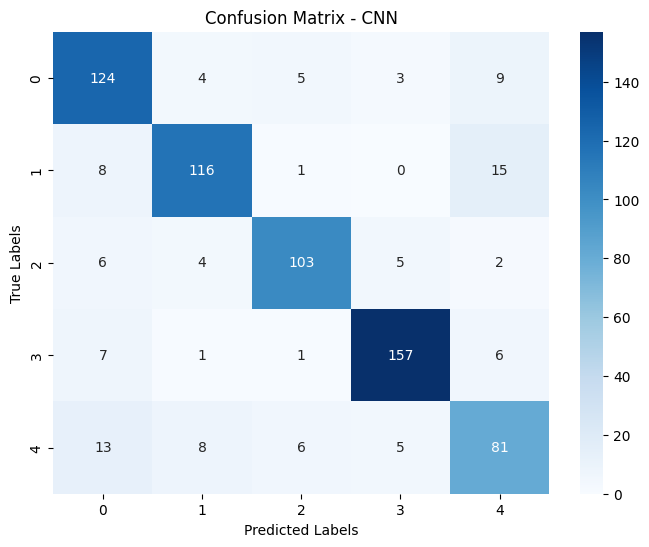

In [48]:
conf_matrix_cnn = confusion_matrix(y_cnn_test, y_cnn_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN')
plt.show()

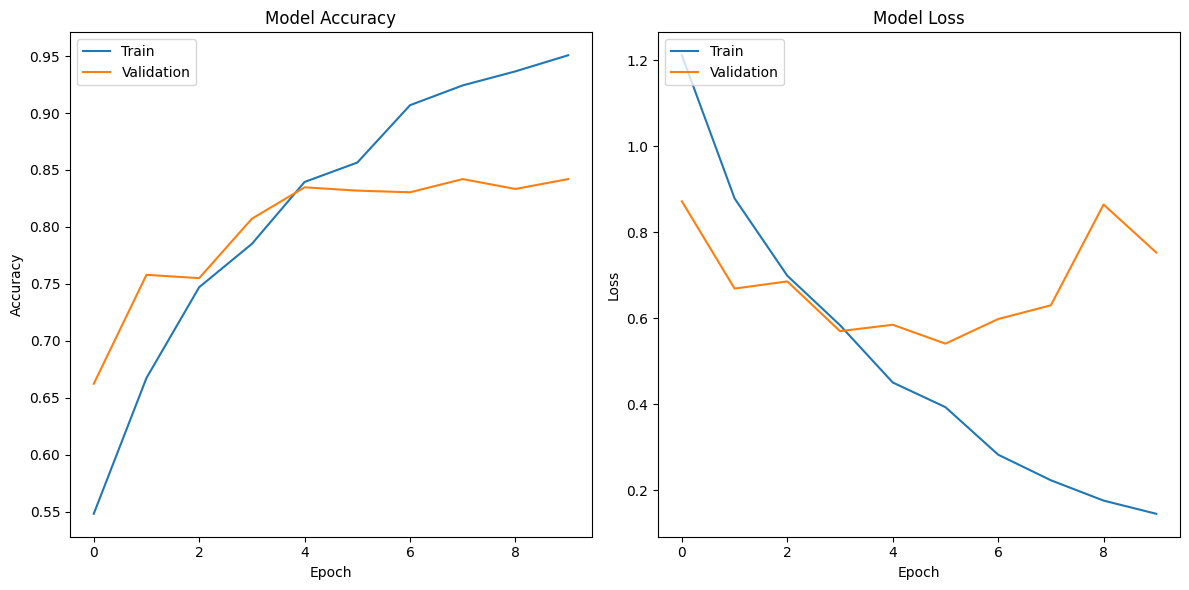

In [49]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()